# Standard SWEI and Heldmyer et. al. Drought classification comparison workflow

In [155]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.integrate import trapz
from scipy.stats import norm
from sklearn.cluster import KMeans

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation, gap_filling, sswei
from snowdroughtindex.utils import visualization

# 1. Data Loading

In [54]:
data_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\casr_data\bow_combined_data.csv'
output_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\modelled_data_snowdrought\\'
shapefile_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\Elevation\Bow_elevation_combined.shp'

In [56]:
# Load data data
CaSR_data = pd.read_csv(data_path)

# Load shapefile for Bow Basin
bow_basin = gpd.read_file(shapefile_path)

# CaSR dataframe
bow_data = CaSR_data[['time', 'Grid_id','lon', 'lat', 'SWE', 'Precipitation', 'Elevation_Category']].copy()
bow_data['time'] = pd.to_datetime(bow_data['time'])

display(bow_data.head())



,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category
0,1980-10-10,1,-116.13797,51.334590,0.878418,0.009879,2000_2500m
1,1982-07-19,1,-116.13797,51.334590,0.515625,2.765854,2000_2500m
2,1983-10-12,2,-116.18750,51.419113,6.875000,0.023846,2000_2500m
3,1980-12-11,2,-116.18750,51.419113,118.125000,4.578907,2000_2500m
4,1981-07-21,2,-116.18750,51.419113,0.000000,5.400473,2000_2500m


# 2. Calculation of climatological mean SWE

In [57]:
# Pivot the table to get mean SWE time series for each elevation category
mean_SWE_by_elev = bow_data.pivot_table(index='time', columns='Elevation_Category', values='SWE', aggfunc='mean')

display(mean_SWE_by_elev)


Elevation_Category,1000_1500m,1500_2000m,2000_2500m,500_1000m
time,,,,
1980-01-01,9.556588,18.021978,82.479169,23.090965
1980-01-02,12.647925,19.409835,83.036111,25.260611
1980-01-03,11.768311,18.534366,81.822222,27.069211
1980-01-04,10.383333,17.111607,81.172222,27.899554
1980-01-05,9.335417,16.311607,80.055556,28.098772
...,...,...,...,...
2023-12-27,4.994759,19.681349,59.825000,1.650675
2023-12-28,4.306356,18.674477,59.371902,1.517384
2023-12-29,3.917008,18.753924,60.202105,1.410878


In [58]:
# Reset the index to make 'time' a regular column
SWE_data_reset = mean_SWE_by_elev.reset_index()

# Convert 'time' column to datetime
SWE_data_reset['time'] = pd.to_datetime(SWE_data_reset['time'])

# Get peak SWE for each elevation category for each year 1981-2010
peak_SWE_by_elev = SWE_data_reset[SWE_data_reset['time'].dt.year.isin(range(1981, 2011))].groupby(
    SWE_data_reset['time'].dt.year)[['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']].max().reset_index()

# Rename the columns for clarity
peak_SWE_by_elev = peak_SWE_by_elev.rename(columns={'time': 'Year'})
peak_SWE_by_elev = peak_SWE_by_elev.rename(columns={col: f'peak_{col}' for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']})

# Display the result
display(peak_SWE_by_elev)

# Save the peak SWE by elevation data
peak_SWE_by_elev.to_csv(output_path + 'peak_SWE_by_elev.csv', index=False)


Elevation_Category,Year,peak_1000_1500m,peak_1500_2000m,peak_2000_2500m,peak_500_1000m
0,1981,24.797070,44.364788,154.827127,28.219308
1,1982,26.354167,44.508929,161.058333,40.208705
2,1983,30.337500,38.036621,161.275000,46.500000
3,1984,28.929175,33.191089,130.524913,34.360491
4,1985,17.887549,36.879576,142.178972,55.231249
5,1986,28.067936,52.775286,220.311111,132.013611
6,1987,24.028027,44.116602,132.038889,76.542821
7,1988,23.063322,41.261482,138.454850,49.833705
8,1989,35.166667,53.646429,172.175000,60.639509
9,1990,25.283854,54.767857,210.295399,68.024567


In [59]:
# 5% of the average peak SWE
# Calculate 5% of the average peak SWE for each elevation category separately
min_SWE_by_category = 0.05 * peak_SWE_by_elev[['peak_1000_1500m', 'peak_1500_2000m', 'peak_2000_2500m', 'peak_500_1000m']].mean()
print(min_SWE_by_category)

Elevation_Category
peak_1000_1500m    1.584179
peak_1500_2000m    2.124508
peak_2000_2500m    7.334886
peak_500_1000m     2.119068
dtype: float64


In [60]:
# Ensure 'time' column is in datetime format
bow_data['time'] = pd.to_datetime(bow_data['time'])
bow_data['Precipitation'] = CaSR_data['Precipitation']

# Define water year for each coordinate_id time series
water_year_grid = bow_data[(bow_data['time'].dt.month >= 10) | (bow_data['time'].dt.month <= 9)]
water_year_grid['Season_year'] = water_year_grid['time'].dt.year
water_year_grid['Season_year'] = water_year_grid['Season_year'].where(water_year_grid['time'].dt.month >= 10, water_year_grid['Season_year'] - 1)

# drop 1979
water_year_grid = water_year_grid[water_year_grid['Season_year'] >= 1980]
#drop 2017
water_year_grid = water_year_grid[water_year_grid['Season_year'] < 2023]
# Display the updated dataframe
display(water_year_grid)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year
0,1980-10-10,1,-116.13797,51.334590,0.878418,0.009879,2000_2500m,1980
1,1982-07-19,1,-116.13797,51.334590,0.515625,2.765854,2000_2500m,1981
2,1983-10-12,2,-116.18750,51.419113,6.875000,0.023846,2000_2500m,1983
3,1980-12-11,2,-116.18750,51.419113,118.125000,4.578907,2000_2500m,1980
4,1981-07-21,2,-116.18750,51.419113,0.000000,5.400473,2000_2500m,1980
...,...,...,...,...,...,...,...,...
4130242,2021-06-25,253,-111.75397,50.070770,0.000000,3.667285,500_1000m,2020
4130243,2020-04-17,253,-111.75397,50.070770,0.902344,0.001052,500_1000m,2019
4130244,2023-04-03,253,-111.75397,50.070770,3.375000,6.179713,500_1000m,2022
4130245,2021-12-15,253,-111.75397,50.070770,1.625000,0.002916,500_1000m,2021


In [61]:
# Save the combined data to a CSV file
bow_data.to_csv(output_path + 'bow_combined_data.csv', index=False)

In [63]:
# Calculate daily SWE change considering each coordinate_id
water_year_grid['daily_SWE_change'] = water_year_grid.groupby(['Grid_id', 'Season_year'])['SWE'].diff().shift(-1)
water_year_grid['daily_SWE_change'] = water_year_grid['daily_SWE_change'].fillna(0)
water_year_grid.loc[water_year_grid['daily_SWE_change'] < 0, 'daily_SWE_change'] = 0

# Display the updated DataFrame
display(water_year_grid)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change
0,1980-10-10,1,-116.13797,51.334590,0.878418,0.009879,2000_2500m,1980,0.000
1,1982-07-19,1,-116.13797,51.334590,0.515625,2.765854,2000_2500m,1981,0.000
2,1983-10-12,2,-116.18750,51.419113,6.875000,0.023846,2000_2500m,1983,0.000
3,1980-12-11,2,-116.18750,51.419113,118.125000,4.578907,2000_2500m,1980,0.000
4,1981-07-21,2,-116.18750,51.419113,0.000000,5.400473,2000_2500m,1980,0.000
...,...,...,...,...,...,...,...,...,...
4130242,2021-06-25,253,-111.75397,50.070770,0.000000,3.667285,500_1000m,2020,0.000
4130243,2020-04-17,253,-111.75397,50.070770,0.902344,0.001052,500_1000m,2019,3.375
4130244,2023-04-03,253,-111.75397,50.070770,3.375000,6.179713,500_1000m,2022,1.250
4130245,2021-12-15,253,-111.75397,50.070770,1.625000,0.002916,500_1000m,2021,0.000


In [161]:
# Initialize an empty DataFrame to store the results
onset_to_peak = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in water_year_grid['Grid_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = water_year_grid[water_year_grid['Grid_id'] == coordinate_id]
    
    # Iterate through each season year for the current coordinate_id
    for year in coord_data['Season_year'].unique():
        # Filter the data for the current season year
        season_data = coord_data[coord_data['Season_year'] == year]
        
        # Get the elevation category for this group
        elev_cat = season_data['Elevation_Category'].iloc[0]
        # Get the correct threshold for this elevation category
        threshold = min_SWE_by_category[f'peak_{elev_cat}']
        # Find the onset date
        onset_date = season_data[season_data['SWE'] >= threshold]['time'].min()
        
        # Find the peak date
        peak_date = season_data[season_data['SWE'] == season_data['SWE'].max()]['time'].values[0]
        
        # Select data from onset to peak
        selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
        
        # Append the selected data to the result DataFrame
        onset_to_peak = pd.concat([onset_to_peak, selected_data])

# Reset the index of the result DataFrame
onset_to_peak.reset_index(drop=True, inplace=True)

# save the result to a CSV file
onset_to_peak.to_csv(output_path + 'onset_to_peak_data.csv', index=False)

# Display the result
display(onset_to_peak)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change
0,1981-02-11,1,-116.13797,51.33459,152.250000,0.000000,2000_2500m,1980,0.570312
1,1980-11-07,1,-116.13797,51.33459,27.000000,2.128011,2000_2500m,1980,0.000000
2,1980-12-21,1,-116.13797,51.33459,110.625000,3.271602,2000_2500m,1980,0.000000
3,1980-10-25,1,-116.13797,51.33459,12.625000,0.000000,2000_2500m,1980,27.875000
4,1980-11-13,1,-116.13797,51.33459,40.500000,0.007695,2000_2500m,1980,13.000000
...,...,...,...,...,...,...,...,...,...
1423250,2022-11-08,257,-111.62024,50.09605,23.125000,5.015135,500_1000m,2022,0.000000
1423251,2022-11-04,257,-111.62024,50.09605,8.500000,0.026440,500_1000m,2022,0.520508
1423252,2022-10-24,257,-111.62024,50.09605,0.625000,4.340502,500_1000m,2022,0.000000
1423253,2022-10-30,257,-111.62024,50.09605,0.000061,0.001129,500_1000m,2022,0.000000


# Standardized SWEI

1. Perturb zeros

In [67]:
onset_to_peak['pertub_SWE'] = sswei.perturb_zeros(onset_to_peak['daily_SWE_change'])

display(onset_to_peak)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change,pertub_SWE
2992,1981-02-11,1,-116.13797,51.33459,152.250000,0.000000,2000_2500m,1980,0.570312,0.570312
31557,1980-11-07,1,-116.13797,51.33459,27.000000,2.128011,2000_2500m,1980,0.000000,0.000002
31560,1980-12-21,1,-116.13797,51.33459,110.625000,3.271602,2000_2500m,1980,0.000000,0.000010
31583,1980-10-25,1,-116.13797,51.33459,12.625000,0.000000,2000_2500m,1980,27.875000,27.875000
31584,1980-11-13,1,-116.13797,51.33459,40.500000,0.007695,2000_2500m,1980,13.000000,13.000000
...,...,...,...,...,...,...,...,...,...,...
4127056,2022-11-08,257,-111.62024,50.09605,23.125000,5.015135,500_1000m,2022,0.000000,0.000011
4127296,2022-11-04,257,-111.62024,50.09605,8.500000,0.026440,500_1000m,2022,0.520508,0.520508
4127353,2022-10-24,257,-111.62024,50.09605,0.625000,4.340502,500_1000m,2022,0.000000,0.000008
4127413,2022-10-30,257,-111.62024,50.09605,0.000061,0.001129,500_1000m,2022,0.000000,0.000013


2. SWE intergration

In [73]:
def integrate_season(group: pd.DataFrame) -> pd.Series:
    """
    Integrate SWE values over a season for each coordinate_id.
    
    Parameters
    ----------
    group : pandas.DataFrame
        DataFrame containing SWE values for a specific coordinate_id and season.
        
    Returns
    -------
    pandas.Series
        Series containing the integrated SWE value for the season.
    """
    # Ensure dates are sorted
    group = group.sort_values(by='time')
    
    # Convert dates to numerical days since the start of the season
    days_since_start = (group['time'] - group['time'].min()).dt.days
    
    # Integrate SWE over the season
    total_swe_integration = trapz(group['SWE'], days_since_start)
    
    return pd.Series({'Grid_id': group['Grid_id'].iloc[0],
                      'Season_year': group['Season_year'].iloc[0],
                      'Elevation_Category': group['Elevation_Category'].iloc[0],
                      'total_SWE_integration': total_swe_integration})

# Apply the integration function to each group of coordinate_id and season_year
SWE_integration = onset_to_peak.groupby(['Grid_id', 'Season_year', 'Elevation_Category']).apply(integrate_season).reset_index(drop=True)

display(SWE_integration)

,Grid_id,Season_year,Elevation_Category,total_SWE_integration
0,1,1980,2000_2500m,27721.888180
1,1,1981,2000_2500m,29420.375244
2,1,1982,2000_2500m,23654.764770
3,1,1983,2000_2500m,18605.812500
4,1,1984,2000_2500m,22005.529297
...,...,...,...,...
11046,257,2018,500_1000m,710.818237
11047,257,2019,500_1000m,0.000000
11048,257,2020,500_1000m,53.292969
11049,257,2021,500_1000m,102.590820


3. Gringorten plotting position

In [80]:
# Apply gringorten_probabilities grouped by coordinate_id
SWE_integration['gringorten_probability'] = SWE_integration.groupby('Grid_id')['total_SWE_integration'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,Season_year,Elevation_Category,total_SWE_integration,gringorten_probability
0,1,1980,2000_2500m,27721.888180,0.755102
1,1,1981,2000_2500m,29420.375244,0.871058
2,1,1982,2000_2500m,23654.764770,0.592764
3,1,1983,2000_2500m,18605.812500,0.384045
4,1,1984,2000_2500m,22005.529297,0.546382
...,...,...,...,...,...
11046,257,2018,500_1000m,710.818237,0.731911
11047,257,2019,500_1000m,0.000000,0.012987
11048,257,2020,500_1000m,53.292969,0.059369
11049,257,2021,500_1000m,102.590820,0.128942


4. Compute Standardized SWEI

In [81]:
# Compute SSWEI grouped by coordinate_id
SWE_integration['SSWEI'] = SWE_integration.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,Season_year,Elevation_Category,total_SWE_integration,gringorten_probability,SSWEI
0,1,1980,2000_2500m,27721.888180,0.755102,0.690633
1,1,1981,2000_2500m,29420.375244,0.871058,1.131404
2,1,1982,2000_2500m,23654.764770,0.592764,0.234662
3,1,1983,2000_2500m,18605.812500,0.384045,-0.294875
4,1,1984,2000_2500m,22005.529297,0.546382,0.116526
...,...,...,...,...,...,...
11046,257,2018,500_1000m,710.818237,0.731911,0.618603
11047,257,2019,500_1000m,0.000000,0.012987,-2.226600
11048,257,2020,500_1000m,53.292969,0.059369,-1.560091
11049,257,2021,500_1000m,102.590820,0.128942,-1.131404


In [83]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = SWE_integration.groupby(['Season_year', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='Season_year', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category,Season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1980,-0.941363,-0.624877,0.313973,-0.851694
1,1981,0.307584,0.265648,0.308140,0.704126
2,1982,-0.215287,0.147100,0.087284,0.654919
3,1983,-0.557649,-0.404771,-0.127808,0.386459
4,1984,-0.283910,0.523561,0.240006,1.071492
5,1985,0.772483,0.952029,1.256569,1.401716
6,1986,0.121657,0.129298,-0.225856,0.802827
7,1987,-0.312637,-0.005976,-0.623339,0.300021
8,1988,0.512149,0.655861,0.512816,1.265374
9,1989,0.716595,1.021759,1.536623,0.865879


5. Classification

In [85]:
# Apply the classify_drought function to each value in the average_SSWEI column
# Apply the classify_drought function to each elevation column
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    average_SSWEI_per_year[f'Classification_{col}'] = average_SSWEI_per_year[col].apply(sswei.classify_drought)

# Do not rename columns here, as the DataFrame now has more columns after classification
# If you want to keep only certain columns, select them explicitly, e.g.:
# average_SSWEI_per_year = average_SSWEI_per_year[['Season_year', '1000_1500m', 'Classification_1000_1500m', ...]]

#remove decimal points from season year
average_SSWEI_per_year['Season_year'] = average_SSWEI_per_year['Season_year'].astype(int)

# Display the updated DataFrame
display(average_SSWEI_per_year)

Elevation_Category,Season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m,Classification_1000_1500m,Classification_1500_2000m,Classification_2000_2500m,Classification_500_1000m
0,1980,-0.941363,-0.624877,0.313973,-0.851694,Moderate Drought,Moderate Drought,Near Normal,Moderate Drought
1,1981,0.307584,0.265648,0.308140,0.704126,Near Normal,Near Normal,Near Normal,Abnormally Wet
2,1982,-0.215287,0.147100,0.087284,0.654919,Near Normal,Near Normal,Near Normal,Abnormally Wet
3,1983,-0.557649,-0.404771,-0.127808,0.386459,Moderate Drought,Near Normal,Near Normal,Near Normal
4,1984,-0.283910,0.523561,0.240006,1.071492,Near Normal,Abnormally Wet,Near Normal,Moderately Wet
5,1985,0.772483,0.952029,1.256569,1.401716,Abnormally Wet,Abnormally Wet,Moderately Wet,Moderately Wet
6,1986,0.121657,0.129298,-0.225856,0.802827,Near Normal,Near Normal,Near Normal,Abnormally Wet
7,1987,-0.312637,-0.005976,-0.623339,0.300021,Near Normal,Near Normal,Moderate Drought,Near Normal
8,1988,0.512149,0.655861,0.512816,1.265374,Abnormally Wet,Abnormally Wet,Abnormally Wet,Moderately Wet
9,1989,0.716595,1.021759,1.536623,0.865879,Abnormally Wet,Moderately Wet,Very Wet,Abnormally Wet


6. Plot timeseries

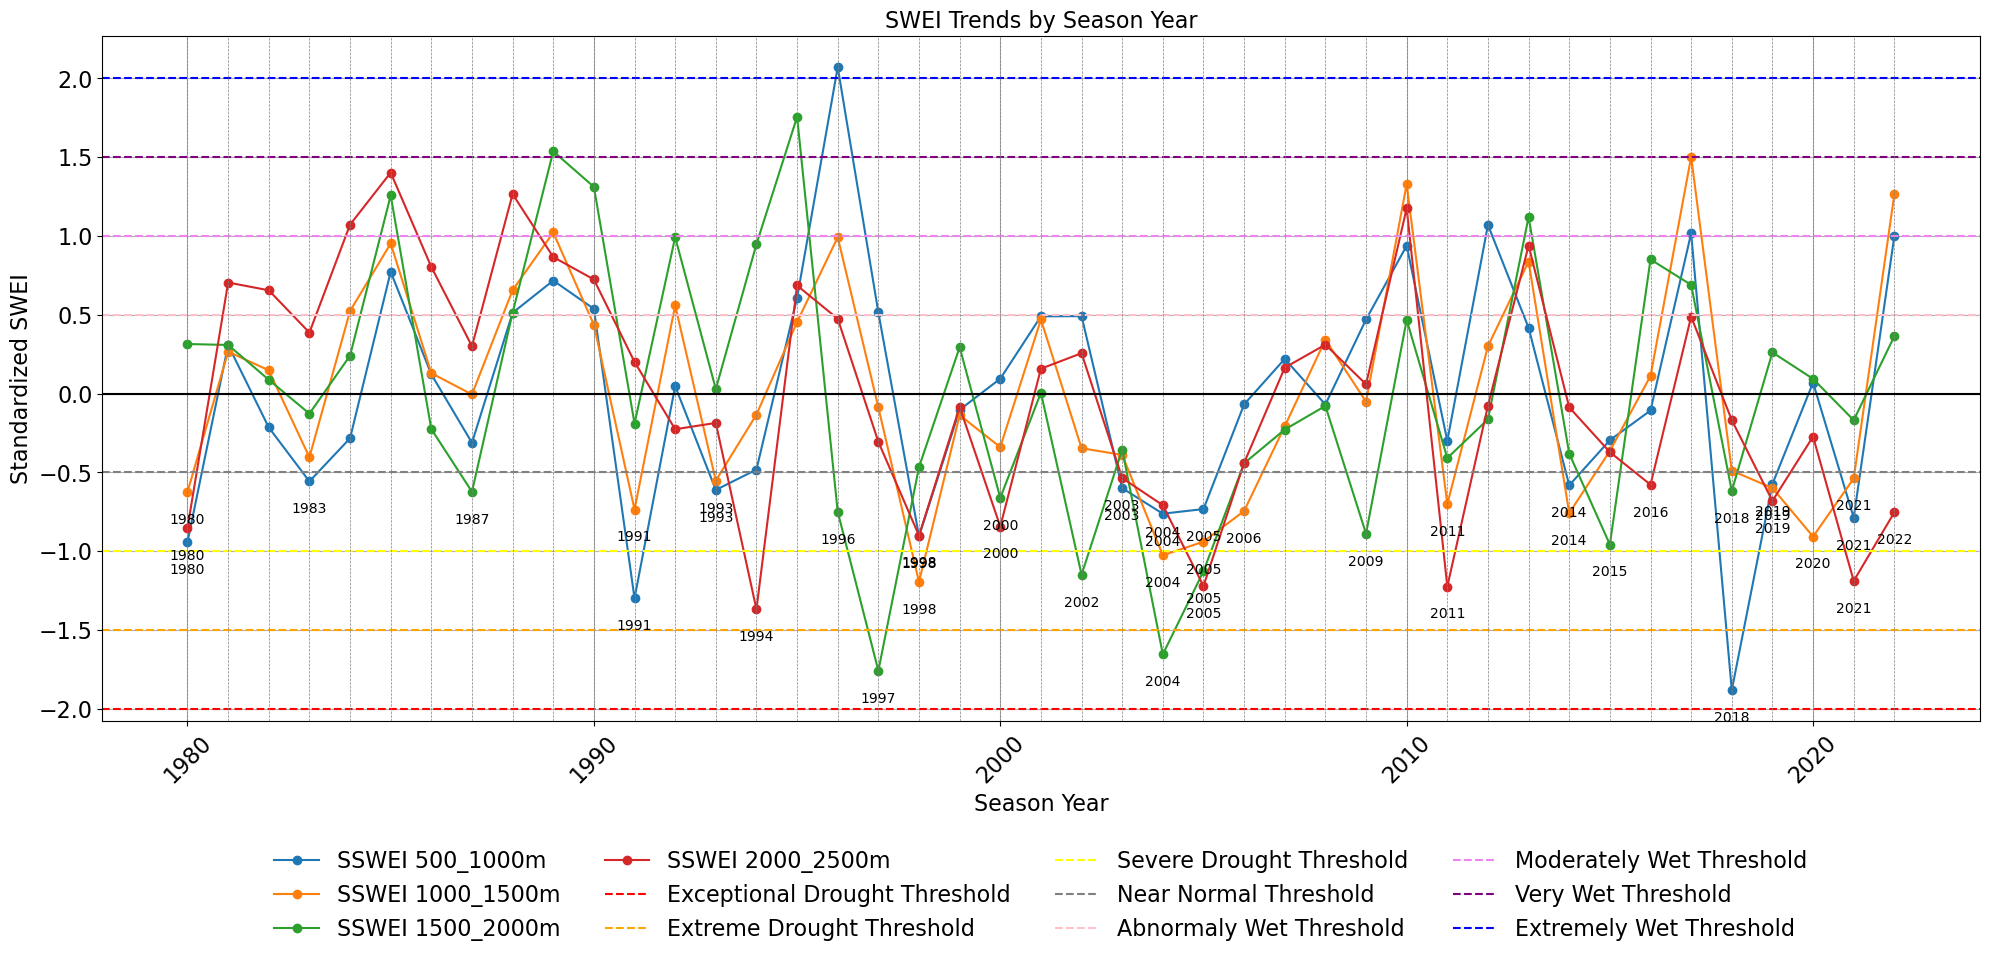

In [124]:
# Prepare data for plotting
plot_data = average_SSWEI_per_year.sort_values(by='Season_year')
plt.figure(figsize=(20, 10))
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    plt.plot(plot_data['Season_year'], plot_data[col], marker='o', label=f'SSWEI {col}')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# trend line
#z = np.polyfit(plot_data['Season_year'], plot_data['SSWEI'], 1)
#p = np.poly1d(z)
#plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year',fontsize=16)
plt.xlabel('Season Year',fontsize=16)
plt.ylabel('Standardized SWEI',fontsize=16)
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)
# put legend outside the plot right top 
plt.legend(['SSWEI 500_1000m', 'SSWEI 1000_1500m', 'SSWEI 1500_2000m', 'SSWEI 2000_2500m',
            'Exceptional Drought Threshold', 'Extreme Drought Threshold', 'Severe Drought Threshold',
            'Near Normal Threshold', 'Abnormaly Wet Threshold', 'Moderately Wet Threshold',
            'Very Wet Threshold', 'Extremely Wet Threshold'],
           loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4, fontsize=16, frameon=False)
# Add gridlines for each year
for year in plot_data['Season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
# Add years to SSWEI < -0.5 for each elevation category
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    for i, row in plot_data.iterrows():
        if row[col] < -0.5:
            plt.text(row['Season_year'], row[col] - 0.2, str(row['Season_year']), fontsize=10, color='black', ha='center')
plt.grid()
plt.axhline(0, color='black', linewidth=1.5, linestyle='-', label='y=0')
plt.tight_layout()
plt.savefig(output_path + 'SWEI_trends.png')
plt.show()
plt.close()

In [130]:
# Open shape file
bow_basin = gpd.read_file(shapefile_path)
display(bow_basin)


,PROVCD_1,VALDATE,EDITION,DATASETNAM,VERSION,COMPLEVEL,WSCMDA,WSCSDA,WSCSSDA,FDA,...,WSCSSDANAM,min,max,mean,count,std,median,PROVCD_2,elev_class,geometry
0,AB,20070208,1,05BM000,0,NHN-CL1,05,05B,05BM,05BM,...,Lower Bow - Crowfoot,776.0,1177.0,953.688214,9897452,71.132927,944.0,NaN,500_1000m,"POLYGON ((-112.58577 51.23024, -112.58519 51.2..."
1,AB,20070130,1,05BN000,0,NHN-CL1,05,05B,05BN,05BN,...,Lower Bow - Mouth,700.0,998.0,772.376015,9312616,32.852467,764.0,NaN,500_1000m,"POLYGON ((-112.49620 50.71881, -112.49566 50.7..."
2,AB,20070226,1,05BH000,0,NHN-CL1,05,05B,05BH,05BH,...,Central Bow - Jumpingpond,1038.0,2479.0,1259.913722,4121228,176.434021,1227.0,NaN,1000_1500m,"POLYGON ((-113.93263 51.12563, -113.93288 51.1..."
3,AB,20070228,1,05BK000,0,NHN-CL1,05,05B,05BK,05BK,...,Fish (Alta.),981.0,1777.0,1226.170423,1151005,126.086335,1194.0,NaN,1000_1500m,"POLYGON ((-114.10188 50.95504, -114.09750 50.9..."
4,AB,20070302,1,05BE000,0,NHN-CL1,05,05B,05BE,05BE,...,Upper Bow - Policeman,1146.0,3054.0,1601.837836,1655101,376.052387,1437.0,NaN,1500_2000m,"POLYGON ((-114.72215 51.33033, -114.72235 51.3..."
5,AB,20070228,1,05BG000,0,NHN-CL1,05,05B,05BG,05BG,...,Ghost,1196.0,3096.0,1782.911133,1683021,373.589221,1639.0,NaN,1500_2000m,"POLYGON ((-115.08500 51.44067, -115.08489 51.4..."
6,AB,20070227,1,05BJ000,0,NHN-CL1,05,05B,05BJ,05BJ,...,Elbow,1052.0,3159.0,1675.498185,2174119,449.060001,1632.0,NaN,1500_2000m,"POLYGON ((-114.05132 50.99912, -114.05104 50.9..."
7,AB,20100901,2,05BL000,1,NHN-CL1,05,05B,05BL,05BL,...,Highwood,949.0,3126.0,1537.674256,6969452,384.815587,1423.0,BC,1500_2000m,"POLYGON ((-115.01619 50.58248, -115.01545 50.5..."
8,AB,20070319,1,05BA000,0,NHN-CL1,05,05B,05BA,05BA,...,Headwaters Bow,1440.0,3490.0,2163.807362,2635914,373.930172,2182.0,NaN,2000_2500m,"POLYGON ((-116.25388 51.71161, -116.25374 51.7..."
9,AB,20070315,1,05BB000,0,NHN-CL1,05,05B,05BB,05BB,...,Upper Bow - Redearth,0.0,3296.0,2076.477015,1325557,359.670055,2122.0,NaN,2000_2500m,"POLYGON ((-115.47260 51.16677, -115.47276 51.1..."


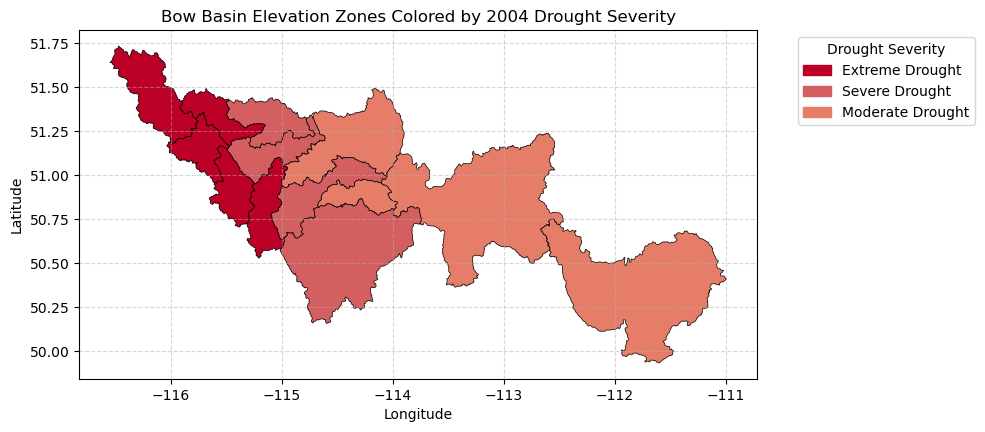

In [134]:
# Filter onset_to_peak for the year 2004
onset_to_peak_2004 = onset_to_peak[onset_to_peak['Season_year'] == 2004]

# Get the classification for 2004 from plot_data
classifications_2004 = plot_data[plot_data['Season_year'] == 2004][[
    'Classification_1000_1500m', 'Classification_1500_2000m', 'Classification_2000_2500m', 'Classification_500_1000m'
]].iloc[0]

# Map elevation category to classification
elev_class_map = {
    '1000_1500m': classifications_2004['Classification_1000_1500m'],
    '1500_2000m': classifications_2004['Classification_1500_2000m'],
    '2000_2500m': classifications_2004['Classification_2000_2500m'],
    '500_1000m': classifications_2004['Classification_500_1000m'],
}

# Add drought classification to the Bow Basin shapefile
bow_basin['Drought_Classification'] = bow_basin['elev_class'].map(elev_class_map)

# Add drought classification to onset_to_peak_2004
onset_to_peak_2004 = onset_to_peak_2004.copy()
onset_to_peak_2004['Drought_Classification'] = onset_to_peak_2004['Elevation_Category'].map(elev_class_map)

# Define a color map for drought severity
severity_colors = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': "#D45F61",
    'Moderate Drought': "#E67D68",
    'Near Normal': '#FFEDA0',
    'Abnormally Wet': '#41B6C4',
    'Moderately Wet': '#1E90FF',
    'Very Wet': '#225EA8',
    'Extremely Wet': '#081D58'
}
# Assign colors to each polygon based on drought classification
bow_basin['color'] = bow_basin['Drought_Classification'].map(severity_colors)

# Plot the Bow Basin colored by drought severity
fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color'], edgecolor='black', linewidth=0.5)

# Create legend patches
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in severity_colors.items() if label in bow_basin['Drought_Classification'].unique()]
plt.legend(handles=legend_patches, title='Drought Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Bow Basin Elevation Zones Colored by 2004 Drought Severity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(output_path + 'bow_basin_drought_severity_2004.png')
plt.show()


# Heldmyer classification

In [162]:
# Add cumulative P values for each season year and coordinate_id
onset_to_peak['cumulative_P'] = onset_to_peak.groupby(['Season_year', 'Grid_id'])['Precipitation'].cumsum()

# If 'Elevation_Category' is missing, merge it back from onset_to_peak
if 'Elevation_Category' not in onset_to_peak.columns:
	onset_to_peak = pd.merge(
		onset_to_peak,
		onset_to_peak[['Season_year', 'Grid_id', 'Elevation_Category']],
		on=['Season_year', 'Grid_id'],
		how='left'
	)

# keep only columns that exist in the DataFrame
cols_to_keep = [col for col in ['Season_year', 'Grid_id','Elevation_Category', 'SWE', 'Precipitation', 'cumulative_P'] if col in onset_to_peak.columns]
onset_to_peak = onset_to_peak[cols_to_keep]

# Display the updated dataframe
display(onset_to_peak)

,Season_year,Grid_id,Elevation_Category,SWE,Precipitation,cumulative_P
0,1980,1,2000_2500m,152.250000,0.000000,0.000000
1,1980,1,2000_2500m,27.000000,2.128011,2.128011
2,1980,1,2000_2500m,110.625000,3.271602,5.399613
3,1980,1,2000_2500m,12.625000,0.000000,5.399613
4,1980,1,2000_2500m,40.500000,0.007695,5.407308
...,...,...,...,...,...,...
1423250,2022,257,500_1000m,23.125000,5.015135,37.280640
1423251,2022,257,500_1000m,8.500000,0.026440,37.307080
1423252,2022,257,500_1000m,0.625000,4.340502,41.647582
1423253,2022,257,500_1000m,0.000061,0.001129,41.648711


In [163]:
# Initialize an empty DataFrame to store the results
onset_to_peak_mean_all = pd.DataFrame()
# Iterate through each coordinate_id
for Grid_id in onset_to_peak['Grid_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = onset_to_peak[onset_to_peak['Grid_id'] == Grid_id]
    
    # Calculate mean_SWE for each season year
    coord_data['mean_SWE'] = coord_data.groupby('Season_year')['SWE'].transform('mean')
    
    # Calculate mean_SWE for each season year and select max cumulative_P for each season year
    onset_to_peak_mean = coord_data.groupby('Season_year').agg(
        mean_SWE=('SWE', 'mean'),
        mean_cumulative_P=('cumulative_P', 'mean'),
        max_SWE=('SWE', 'max'),
        max_cumulative_P=('cumulative_P', 'max'),
        Elevation_Category=('Elevation_Category', 'first'),
        Grid_id=('Grid_id', 'first'),
    ).reset_index()

    # calculate cumulative P anomaly
    onset_to_peak_mean['cumulative_P_anomaly'] = onset_to_peak_mean['mean_cumulative_P'] - onset_to_peak_mean['mean_cumulative_P'].mean()
    
    # Calculate mean_SWE/max_cumulative_P ratio
    onset_to_peak_mean['mean_SWE/cumulative_P'] = onset_to_peak_mean['mean_SWE'] / onset_to_peak_mean['max_cumulative_P']
    
    # Add coordinate_id to the result
    onset_to_peak_mean['Grid_id'] = Grid_id
    
    # Append the result to the final DataFrame
    onset_to_peak_mean_all = pd.concat([onset_to_peak_mean_all, onset_to_peak_mean])

# Display the result
display(onset_to_peak_mean_all)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_29712\2931941036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('Season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_29712\2931941036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('Season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_29712\2931941036.py:9: Settin

,Season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,Elevation_Category,Grid_id,cumulative_P_anomaly,mean_SWE/cumulative_P
0,1980,137.188027,139.537499,240.625000,300.622847,2000_2500m,1,-13.084497,0.456346
1,1981,133.778282,174.430574,277.000000,304.617267,2000_2500m,1,21.808577,0.439168
2,1982,125.244157,89.821195,273.875000,193.606993,2000_2500m,1,-62.800801,0.646899
3,1983,103.946528,85.816878,200.375000,174.469960,2000_2500m,1,-66.805118,0.595785
4,1984,104.866549,105.514577,227.750000,213.305598,2000_2500m,1,-47.107420,0.491626
...,...,...,...,...,...,...,...,...,...
38,2018,1.998367,115.676308,29.321777,213.924215,500_1000m,257,84.051954,0.009341
39,2019,25.625000,0.374824,25.625000,0.374824,500_1000m,257,-31.249531,68.365420
40,2020,2.468447,21.672118,23.875000,42.678873,500_1000m,257,-9.952236,0.057838
41,2021,1.451485,10.410784,16.000000,25.155794,500_1000m,257,-21.213571,0.057700


In [164]:
# Group by 'Season_year' and 'Elevation_Category', take mean, and reset index to ensure columns are accessible
mean_over_coordinate_id = onset_to_peak_mean_all.groupby(['Season_year', 'Elevation_Category']).mean(numeric_only=True).reset_index()

display(mean_over_coordinate_id)


,Season_year,Elevation_Category,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,Grid_id,cumulative_P_anomaly,mean_SWE/cumulative_P
0,1980,1000_1500m,7.559207,29.829978,40.117253,58.444802,122.966667,-9.314385,0.154237
1,1980,1500_2000m,10.900337,82.662666,56.006445,166.828407,81.700000,14.668424,0.102288
2,1980,2000_2500m,78.302475,155.321119,157.767231,305.037354,34.044444,36.550669,0.256236
3,1980,500_1000m,8.390238,18.610409,41.898997,36.930056,198.330357,-10.222194,0.241671
4,1981,1000_1500m,7.647846,30.453542,29.995833,60.815449,122.966667,-8.690821,0.140385
...,...,...,...,...,...,...,...,...,...
167,2021,500_1000m,3.255155,17.129613,18.092634,34.692931,198.330357,-11.702990,0.097067
168,2022,1000_1500m,13.854120,55.958083,35.062321,114.329659,122.966667,16.813720,0.132524
169,2022,1500_2000m,38.921259,62.638894,77.369643,128.665325,81.700000,-5.355348,0.283753
170,2022,2000_2500m,92.108544,83.013855,172.063889,165.324967,34.044444,-35.756596,0.563100


In [168]:
# Get drought years from plot_data where any elevation category is classified as drought
drought_classes = ['Moderate Drought', 'Severe Drought', 'Extreme Drought', 'Exceptional Drought']
drought_years = plot_data[
    (plot_data['Classification_1000_1500m'].isin(drought_classes)) |
    (plot_data['Classification_1500_2000m'].isin(drought_classes)) |
    (plot_data['Classification_2000_2500m'].isin(drought_classes)) |
    (plot_data['Classification_500_1000m'].isin(drought_classes))
]['Season_year'].unique()

# Filter onset_to_peak for these drought years
onset_to_peak_drought = mean_over_coordinate_id[mean_over_coordinate_id['Season_year'].isin(drought_years)]

#save the drought data to a CSV file
onset_to_peak_drought.to_csv(output_path + 'onset_to_peak_drought_data.csv', index=False)

display(onset_to_peak_drought)

,Season_year,Elevation_Category,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,Grid_id,cumulative_P_anomaly,mean_SWE/cumulative_P
0,1980,1000_1500m,7.559207,29.829978,40.117253,58.444802,122.966667,-9.314385,0.154237
1,1980,1500_2000m,10.900337,82.662666,56.006445,166.828407,81.700000,14.668424,0.102288
2,1980,2000_2500m,78.302475,155.321119,157.767231,305.037354,34.044444,36.550669,0.256236
3,1980,500_1000m,8.390238,18.610409,41.898997,36.930056,198.330357,-10.222194,0.241671
12,1983,1000_1500m,9.798146,13.728265,30.662508,26.165594,122.966667,-25.416098,0.398197
...,...,...,...,...,...,...,...,...,...
167,2021,500_1000m,3.255155,17.129613,18.092634,34.692931,198.330357,-11.702990,0.097067
168,2022,1000_1500m,13.854120,55.958083,35.062321,114.329659,122.966667,16.813720,0.132524
169,2022,1500_2000m,38.921259,62.638894,77.369643,128.665325,81.700000,-5.355348,0.283753
170,2022,2000_2500m,92.108544,83.013855,172.063889,165.324967,34.044444,-35.756596,0.563100


In [169]:
# print drought years for each elevation category
# Get drought years for each elevation category
elev_cols = ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']
drought_years_by_elev = {}

for col in elev_cols:
    class_col = f'Classification_{col}'
    drought_years_by_elev[col] = plot_data.loc[
        plot_data[class_col].isin(drought_classes), 'Season_year'
    ].tolist()

for elev, years in drought_years_by_elev.items():
    print(f"Drought Years for {elev}: {years}")
# save drought years to a CSV file
drought_years_df = pd.DataFrame({
    'Elevation_Category': elev_cols,
    'Drought_Years': [drought_years_by_elev[elev] for elev in elev_cols]
})
#show in the dataframe
drought_years_df = drought_years_df.explode('Drought_Years').reset_index(drop=True)
# Save the drought years DataFrame to a CSV file
drought_years_df['Drought_Years'] = drought_years_df['Drought_Years'].astype(int)  # Ensure Drought_Years are integers
drought_years_df = drought_years_df.sort_values(by='Elevation_Category')
drought_years_df.to_csv(output_path + 'drought_years_by_elevation.csv', index=False)
print("Drought Years:", drought_years)


Drought Years for 1000_1500m: [1980, 1983, 1991, 1993, 1998, 2003, 2004, 2005, 2014, 2018, 2019, 2021]
Drought Years for 1500_2000m: [1980, 1991, 1993, 1998, 2004, 2005, 2006, 2011, 2014, 2019, 2020, 2021]
Drought Years for 2000_2500m: [1987, 1996, 1997, 2000, 2002, 2004, 2005, 2009, 2015, 2018]
Drought Years for 500_1000m: [1980, 1994, 1998, 2000, 2003, 2004, 2005, 2011, 2016, 2019, 2021, 2022]
Drought Years: [1980 1983 1987 1991 1993 1994 1996 1997 1998 2000 2002 2003 2004 2005
 2006 2009 2011 2014 2015 2016 2018 2019 2020 2021 2022]


In [171]:
# Get non-drought years (years not in drought_years)
non_drought_years = [year for year in plot_data['Season_year'] if year not in drought_years]

# Filter onset_to_peak for these non-drought years
onset_to_peak_non_drought = mean_over_coordinate_id[mean_over_coordinate_id['Season_year'].isin(non_drought_years)]

# Save the non-drought data to a CSV file
onset_to_peak_non_drought.to_csv(output_path + 'onset_to_peak_non_drought_data.csv', index=False)

# Display the result
display(onset_to_peak_non_drought)

,Season_year,Elevation_Category,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,Grid_id,cumulative_P_anomaly,mean_SWE/cumulative_P
4,1981,1000_1500m,7.647846,30.453542,29.995833,60.815449,122.966667,-8.690821,0.140385
5,1981,1500_2000m,13.501754,56.947120,45.382143,112.808562,81.700000,-11.047122,0.129293
6,1981,2000_2500m,76.511046,120.356301,167.513889,239.236441,34.044444,1.585851,0.302091
7,1981,500_1000m,16.360142,35.327184,43.205357,69.296018,198.330357,6.494581,0.240832
8,1982,1000_1500m,5.103129,28.333832,17.079167,56.644184,122.966667,-10.810531,0.099991
...,...,...,...,...,...,...,...,...,...
135,2013,500_1000m,35.715613,37.599168,74.879560,75.496376,198.330357,8.766565,0.452934
148,2017,1000_1500m,14.074774,60.586168,49.833333,116.468413,122.966667,21.441805,0.112559
149,2017,1500_2000m,35.450362,95.945557,99.716211,190.307766,81.700000,27.951315,0.176341
150,2017,2000_2500m,95.605472,145.996900,199.766667,289.120333,34.044444,27.226449,0.324307


K mean Clustering for snow drought years

In [172]:
# Standardize cumulative_P_anomaly and mean_SWE/cumulative_P for each elevation category
onset_to_peak_drought['cumulative_P_anomaly_z'] = onset_to_peak_drought.groupby('Elevation_Category')['cumulative_P_anomaly'].transform(
    lambda x: (x - x.mean()) / x.std()
)
onset_to_peak_drought['mean_SWE/cumulative_P_z'] = onset_to_peak_drought.groupby('Elevation_Category')['mean_SWE/cumulative_P'].transform(
    lambda x: (x - x.mean()) / x.std()
)

display(onset_to_peak_drought)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_29712\2494528000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_to_peak_drought['cumulative_P_anomaly_z'] = onset_to_peak_drought.groupby('Elevation_Category')['cumulative_P_anomaly'].transform(
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_29712\2494528000.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_to_peak_drought['mean_SWE/cumulative_P_z'] = onset_to_peak_drought.groupby('Elevation_Category')['mean_SWE/cumula

,Season_year,Elevation_Category,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,Grid_id,cumulative_P_anomaly,mean_SWE/cumulative_P,cumulative_P_anomaly_z,mean_SWE/cumulative_P_z
0,1980,1000_1500m,7.559207,29.829978,40.117253,58.444802,122.966667,-9.314385,0.154237,-0.564801,-0.200363
1,1980,1500_2000m,10.900337,82.662666,56.006445,166.828407,81.700000,14.668424,0.102288,0.509133,-0.201623
2,1980,2000_2500m,78.302475,155.321119,157.767231,305.037354,34.044444,36.550669,0.256236,1.495673,-0.959427
3,1980,500_1000m,8.390238,18.610409,41.898997,36.930056,198.330357,-10.222194,0.241671,-0.552854,-0.203836
12,1983,1000_1500m,9.798146,13.728265,30.662508,26.165594,122.966667,-25.416098,0.398197,-1.706921,-0.192668
...,...,...,...,...,...,...,...,...,...,...,...
167,2021,500_1000m,3.255155,17.129613,18.092634,34.692931,198.330357,-11.702990,0.097067,-0.645266,-0.230223
168,2022,1000_1500m,13.854120,55.958083,35.062321,114.329659,122.966667,16.813720,0.132524,1.288507,-0.201048
169,2022,1500_2000m,38.921259,62.638894,77.369643,128.665325,81.700000,-5.355348,0.283753,-0.207362,-0.195397
170,2022,2000_2500m,92.108544,83.013855,172.063889,165.324967,34.044444,-35.756596,0.563100,-1.032106,2.419450


In [180]:
# check if there are values >1 in mean_SWE/cumulative_P_z
if (onset_to_peak_drought['mean_SWE/cumulative_P_z'] > 1).any():
    print("There are values greater than 1 in mean_SWE/cumulative_P_z")
    display(onset_to_peak_drought[onset_to_peak_drought['mean_SWE/cumulative_P_z'] > 1])
else:
    print("There are no values greater than 1 in mean_SWE/cumulative_P_z")



There are values greater than 1 in mean_SWE/cumulative_P_z


,Season_year,Elevation_Category,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,Grid_id,cumulative_P_anomaly,mean_SWE/cumulative_P,cumulative_P_anomaly_z,mean_SWE/cumulative_P_z,cluster,cluster_name
142,2015,2000_2500m,68.275528,96.052745,118.864236,155.740448,34.044444,-22.717706,0.455565,-0.576281,1.235380,0,Warm
156,2019,1000_1500m,14.969287,39.536285,27.587695,73.564253,122.966667,0.391922,158.688343,0.123682,4.799949,2,Dry
157,2019,1500_2000m,31.461920,49.391063,48.411114,92.944711,81.700000,-18.603179,145.868811,-0.681399,4.799980,1,Warm & Dry
159,2019,500_1000m,20.434377,15.899902,36.090402,30.717340,198.330357,-12.932701,27.640175,-0.722007,4.795799,1,Warm & Dry
170,2022,2000_2500m,92.108544,83.013855,172.063889,165.324967,34.044444,-35.756596,0.563100,-1.032106,2.419450,0,Warm


In [173]:
from sklearn.cluster import KMeans

# K-means clustering
# Perform K-means clustering for each elevation category separately

for elev in elev_cols:
    subset = onset_to_peak_drought[onset_to_peak_drought['Elevation_Category'] == elev]
    cluster_feature = subset[['mean_SWE/cumulative_P_z', 'cumulative_P_anomaly_z']]
    kmean = KMeans(n_clusters=3, random_state=0)
    onset_to_peak_drought.loc[subset.index, 'cluster'] = kmean.fit_predict(cluster_feature)
    print(f"Cluster centers for {elev}:\n", kmean.cluster_centers_)

onset_to_peak_drought['cluster'] = onset_to_peak_drought['cluster'].astype(int)
print("\nAssigned clusters:\n", onset_to_peak_drought[['Season_year', 'cluster']])

Cluster centers for 1000_1500m:
 [[-0.20225277  0.86740032]
 [-0.197743   -0.8777072 ]
 [ 4.79994933  0.12368247]]
Cluster centers for 1500_2000m:
 [[-0.19986924 -0.14073775]
 [ 4.79998025 -0.68139947]
 [-0.20298779  3.91836773]]
Cluster centers for 2000_2500m:
 [[ 0.75541435 -0.83742128]
 [-1.27301277  0.81244935]
 [-0.02564714  0.72698499]]
Cluster centers for 500_1000m:
 [[-0.19872222 -0.14170495]
 [ 4.79579878 -0.72200747]
 [-0.22518762  3.98122141]]

Assigned clusters:
      Season_year  cluster
0           1980        1
1           1980        0
2           1980        1
3           1980        0
12          1983        1
..           ...      ...
167         2021        0
168         2022        0
169         2022        0
170         2022        0
171         2022        0

[100 rows x 2 columns]


c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\walimunige.rupasingh\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_29712\1969137694.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onse

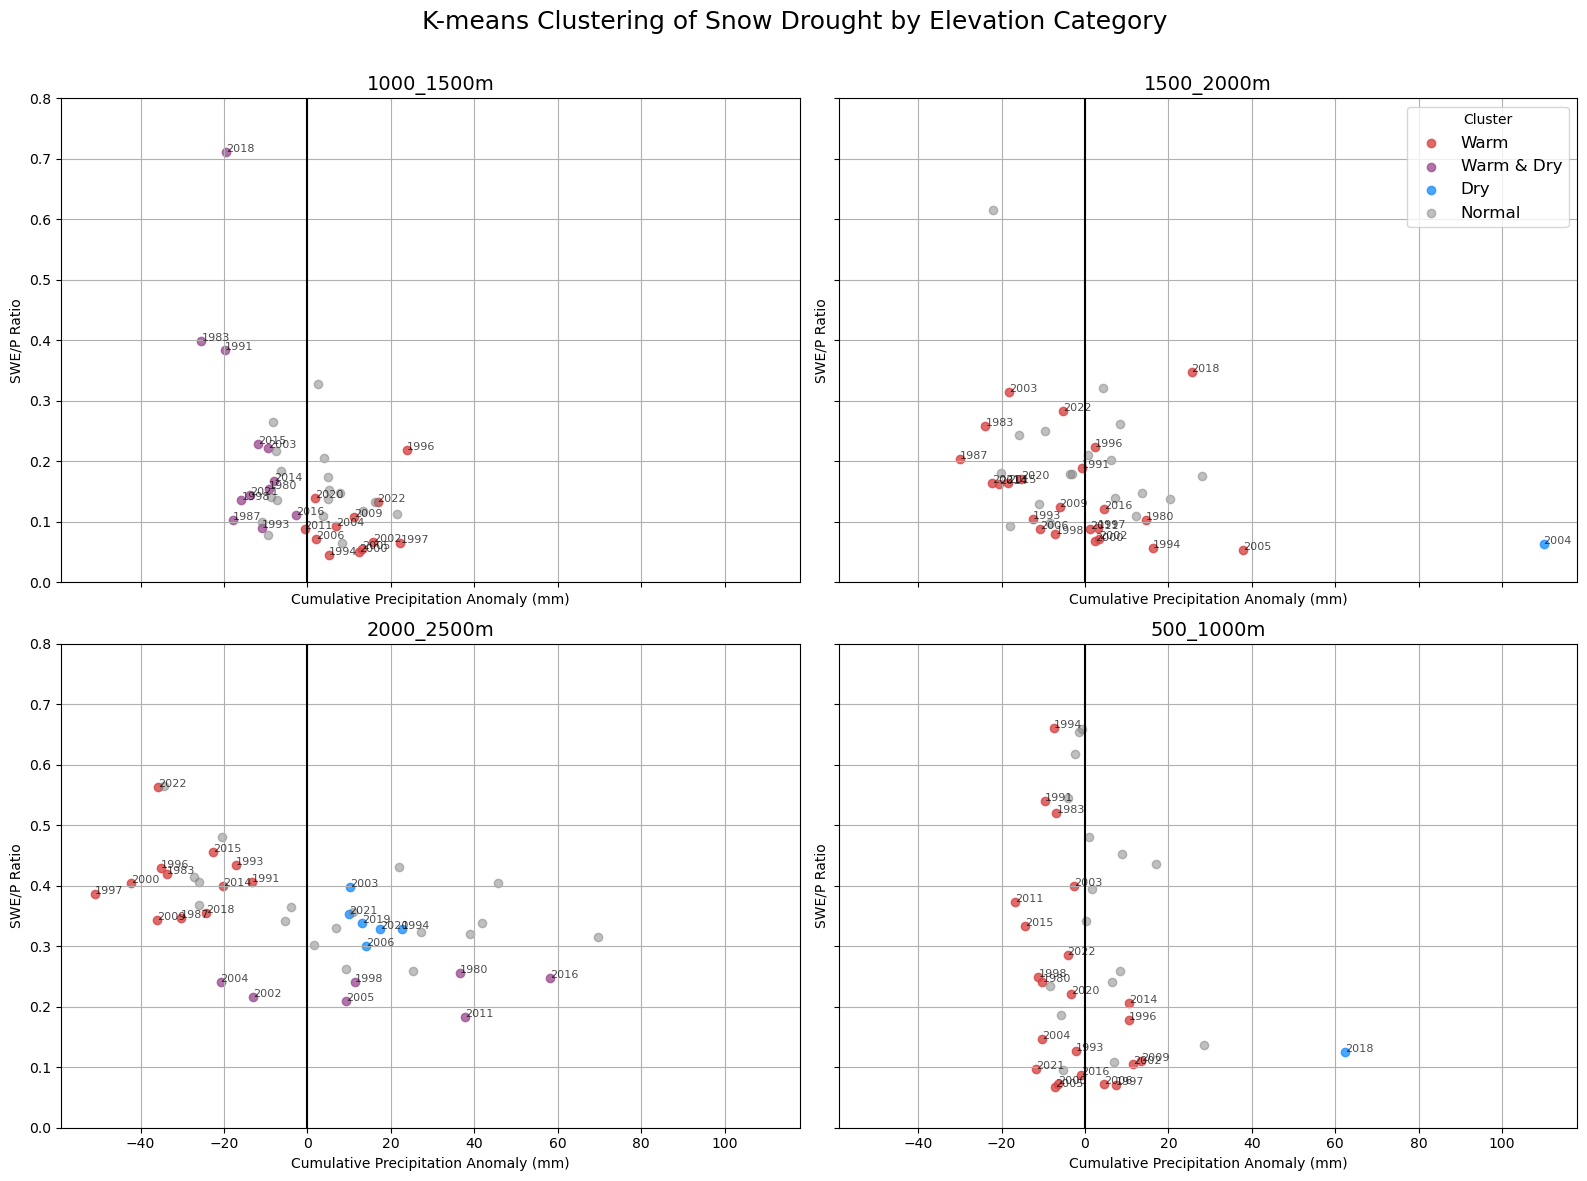

In [184]:
# Define cluster colors for plotting
cluster_colors = {
    "Warm": "#D84545",         # orange
    "Warm & Dry": "#9E5194",   # reddish
    "Dry": "#1E90FF",          # blue
    # Add more cluster names and colors as needed
}

# Create subplots for each elevation category
elevations = onset_to_peak_drought['Elevation_Category'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, elev in enumerate(elevations):
    ax = axes[i]
    drought_subset = onset_to_peak_drought[onset_to_peak_drought['Elevation_Category'] == elev]
    non_drought_subset = onset_to_peak_non_drought[onset_to_peak_non_drought['Elevation_Category'] == elev]

    # Plot drought years with clusters
    for cname, color in cluster_colors.items():
        cluster_points = drought_subset[drought_subset['cluster_name'] == cname]
        ax.scatter(
            cluster_points['cumulative_P_anomaly'],
            cluster_points['mean_SWE/cumulative_P'],
            color=color,
            label=cname if i == 0 else "",  # Only label once for legend
            alpha=0.8
        )
    # Plot non-drought years
    ax.scatter(
        non_drought_subset['cumulative_P_anomaly'],
        non_drought_subset['mean_SWE/cumulative_P'],
        color='grey',
        label='Normal' if i == 0 else "",
        alpha=0.5
    )
    # Annotate drought years
    for _, row in drought_subset.iterrows():
        ax.annotate(int(row['Season_year']), (row['cumulative_P_anomaly'], row['mean_SWE/cumulative_P']), fontsize=8, color='black', alpha=0.7)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='-')
    ax.set_title(f'{elev}', fontsize=14)
    ax.set_xlabel('Cumulative Precipitation Anomaly (mm)')
    ax.set_ylabel('SWE/P Ratio')
    ax.grid(True)

# Add legend to the first subplot only
handles, labels = axes[0].get_legend_handles_labels()
# Place legend inside the top right subplot (axes[1])
axes[1].legend(handles, labels, title='Cluster', loc='upper right', fontsize=12)
plt.suptitle('K-means Clustering of Snow Drought by Elevation Category', fontsize=18)
plt.ylim(0,0.8)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(output_path + 'K-means_Clustering_Subplots_by_Elevation.png')
plt.show()